In [1]:
import pandas as pd

### Data Loading

In [2]:
dfList = []
for i in range(1,32):
    print(".",end='', flush=True)
    dfList.append(pd.read_json("./fraud-data/2017-01-{0:02d}.txt".format(i), lines=True))
print("done!")
df = pd.concat(dfList)

...............................done!


In [3]:
print(df.fraudLabel.value_counts())
df.head()

0    30106
1      894
Name: fraudLabel, dtype: int64


,basket,fraudLabel,totalAmount,transactionId,zipCode
0,[1],0,58,6707871407,2196
1,"[2, 1, 5, 4, 2]",0,50,3459351507,5252
2,"[0, 4, 5, 1, 4]",0,390,7881605492,2696
3,"[3, 4, 2, 2, 0, 4, 3]",0,637,8168380925,5093
4,"[2, 4, 5]",0,111,4691340970,3855


### Feature Engineering

In [4]:
df['c_0'] = df.basket.map(lambda x: x.count(0))
df['c_1'] = df.basket.map(lambda x: x.count(1))
df['c_2'] = df.basket.map(lambda x: x.count(2))
df['c_3'] = df.basket.map(lambda x: x.count(3))
df['c_4'] = df.basket.map(lambda x: x.count(4))

In [5]:
df.head()

,basket,fraudLabel,totalAmount,transactionId,zipCode,c_0,c_1,c_2,c_3,c_4
0,[1],0,58,6707871407,2196,0,1,0,0,0
1,"[2, 1, 5, 4, 2]",0,50,3459351507,5252,0,1,2,0,1
2,"[0, 4, 5, 1, 4]",0,390,7881605492,2696,1,1,0,0,2
3,"[3, 4, 2, 2, 0, 4, 3]",0,637,8168380925,5093,1,0,2,2,2
4,"[2, 4, 5]",0,111,4691340970,3855,0,0,1,0,1


In [6]:
df["zipCode"] = df["zipCode"].astype('category',categories=[i for i in list(range(1000,10000))])
dummies = pd.get_dummies(df.zipCode)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """Entry point for launching an IPython kernel.


In [7]:
dummies.shape

(31000, 9000)

In [8]:
df2 = pd.concat([df, dummies], axis=1)

In [9]:
df3 = df2.drop(["basket", "zipCode", "transactionId"], axis=1)

In [10]:
df3.head()

,fraudLabel,totalAmount,c_0,c_1,c_2,c_3,c_4,1000,1001,1002,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,58,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,50,0,1,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,390,1,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,637,1,0,2,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,111,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model training

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df3, test_size=0.3, random_state=0)
# save predictions to csv
train.to_pickle("./data/train.pickle")
test.to_pickle("./data/test.pickle")
train.head()

,fraudLabel,totalAmount,c_0,c_1,c_2,c_3,c_4,1000,1001,1002,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
281,0,35,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57,0,10,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
273,0,186,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
725,0,54,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,0,30,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
X_train = train[train.columns[1:]]
y_train = train["fraudLabel"]
X_test = test[test.columns[1:]]
y_test = test["fraudLabel"]
X_train.shape

(21700, 9006)

In [13]:
from sklearn.linear_model import LogisticRegression
# Setting the model 
logreg = LogisticRegression()
# Fitting the model 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
logreg.coef_.shape

(1, 9006)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()
gbt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Model evaluation

In [15]:
test_scores_reg = logreg.predict_proba(X_test)
test_scores_gbt = gbt.predict_proba(X_test)

In [31]:
test_scores_reg

array([[0.85618863, 0.14381137],
       [0.98985823, 0.01014177],
       [0.99803231, 0.00196769],
       ...,
       [0.97977667, 0.02022333],
       [0.98332138, 0.01667862],
       [0.94757919, 0.05242081]])

In [16]:
from sklearn import metrics
fpr_reg, tpr_reg, _ =  metrics.roc_curve(y_test, test_scores_reg[:,1])
auc_reg = metrics.auc(fpr_reg, tpr_reg)
fpr_gbt, tpr_gbt, _ =  metrics.roc_curve(y_test, test_scores_gbt[:,1])
auc_gbt = metrics.auc(fpr_gbt, tpr_gbt)

In [17]:
# save predictions to csv
df = pd.DataFrame(data={'label': y_test, 'predReg': test_scores_reg[:,1], 
                  'predGbt': test_scores_gbt[:,1] })
df.to_csv("./data/predictions.csv", index=False)

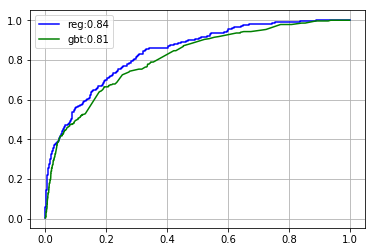

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_reg, tpr_reg, color = 'blue', label = "reg:{:.2f}".format(auc_reg))
plt.plot(fpr_gbt, tpr_gbt, color = 'green', label = "gbt:{:.2f}".format(auc_gbt))
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


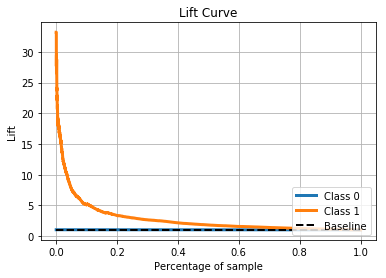

In [25]:
import scikitplot as skplt

skplt.metrics.plot_lift_curve(y_test, test_scores_reg)



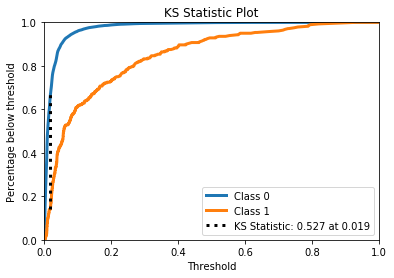

In [26]:
skplt.metrics.plot_ks_statistic(y_test, test_scores_reg)